# Data Augmentation para Dataset CNN

Este notebook genera imágenes aumentadas para entrenar modelos de CNN con un dataset más robusto.

**Estructura del dataset:**
```
dataset/
├── all_benign/
├── all_early/
├── all_pre/
└── all_pro/
```

## 1. Importar Librerías

In [1]:
import torch
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
CUDA available: True


## 2. Configuración

In [2]:
# Configuración del dataset
DATASET_DIR = "dataset"
CLASES = ["kidney_normal", "kidney_tumor"]
IMAGENES_POR_CLASE = 1000  # Número de imágenes nuevas a generar por clase
EJEMPLOS_A_MOSTRAR = 3  # Ejemplos a visualizar por clase

print(f"📂 Directorio: {DATASET_DIR}")
print(f"📊 Clases: {CLASES}")
print(f"🎯 Objetivo: {IMAGENES_POR_CLASE} imágenes nuevas por clase")

📂 Directorio: dataset
📊 Clases: ['kidney_normal', 'kidney_tumor']
🎯 Objetivo: 1000 imágenes nuevas por clase


## 3. Definir Transformaciones

Las transformaciones aplicadas son:
- **Rotación aleatoria** hasta 30°
- **Flip horizontal** (50% probabilidad)
- **Flip vertical** (30% probabilidad)
- **Ajuste de color** (brillo, contraste, saturación, tono)
- **Transformaciones afines** (traslación y escala)

In [3]:
# Transformaciones para augmentation
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

print("✅ Transformaciones definidas")

✅ Transformaciones definidas


## 4. Visualizar Ejemplos de Augmentation

Antes de generar todas las imágenes, veamos algunos ejemplos de cómo se ven las transformaciones.


✅ Visualización guardada como 'comparacion_augmentacion.png'


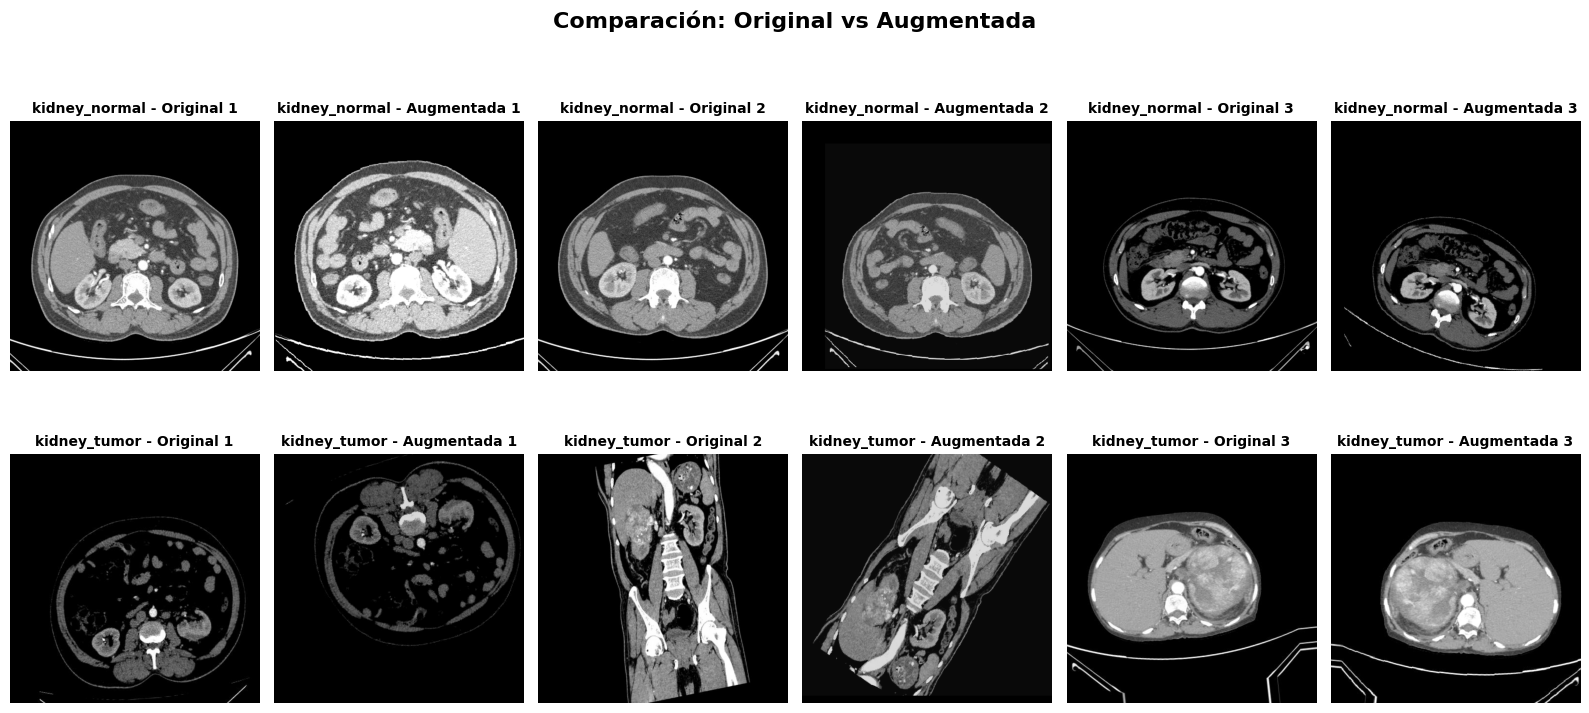

In [4]:
def visualizar_augmentacion(num_ejemplos=3):
    """Muestra ejemplos de imágenes originales y aumentadas para cada clase"""
    
    # Crear figura grande
    fig, axes = plt.subplots(len(CLASES), num_ejemplos * 2, 
                             figsize=(16, 4 * len(CLASES)))
    fig.suptitle('Comparación: Original vs Augmentada', fontsize=16, fontweight='bold')
    
    for i, clase in enumerate(CLASES):
        class_path = Path(DATASET_DIR) / clase
        
        # Obtener imágenes de la clase
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        if not image_files:
            print(f"⚠️  No se encontraron imágenes en {clase}")
            continue
        
        # Seleccionar imágenes aleatorias
        selected_images = random.sample(image_files, min(num_ejemplos, len(image_files)))
        
        for j, img_file in enumerate(selected_images):
            img_path = class_path / img_file
            
            # Cargar imagen original
            img_original = Image.open(img_path).convert('RGB')
            
            # Generar imagen aumentada
            img_augmented = transform(img_original)
            
            # Mostrar imagen original
            col_idx = j * 2
            ax_orig = axes[i, col_idx]
            ax_orig.imshow(img_original)
            ax_orig.axis('off')
            ax_orig.set_title(f'{clase} - Original {j+1}', fontweight='bold', fontsize=10)
            
            # Mostrar imagen aumentada
            col_idx = j * 2 + 1
            ax_aug = axes[i, col_idx]
            ax_aug.imshow(img_augmented)
            ax_aug.axis('off')
            ax_aug.set_title(f'{clase} - Augmentada {j+1}', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('comparacion_augmentacion.png', dpi=150, bbox_inches='tight')
    print("\n✅ Visualización guardada como 'comparacion_augmentacion.png'")
    plt.show()

# Ejecutar visualización
if os.path.exists(DATASET_DIR):
    visualizar_augmentacion(EJEMPLOS_A_MOSTRAR)
else:
    print(f"❌ Error: No se encuentra el directorio '{DATASET_DIR}'")

## 5. Verificar Estado Actual del Dataset

In [5]:
def contar_imagenes():
    """Cuenta el número de imágenes en cada clase"""
    print("\n📊 Estado actual del dataset:\n")
    print(f"{'Clase':<15} {'Imágenes':>10}")
    print("-" * 27)
    
    total = 0
    for clase in CLASES:
        class_path = Path(DATASET_DIR) / clase
        if os.path.exists(class_path):
            num_imgs = len([f for f in os.listdir(class_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
            print(f"{clase:<15} {num_imgs:>10}")
            total += num_imgs
        else:
            print(f"{clase:<15} {'No existe':>10}")
    
    print("-" * 27)
    print(f"{'TOTAL':<15} {total:>10}")

contar_imagenes()


📊 Estado actual del dataset:

Clase             Imágenes
---------------------------
kidney_normal         5000
kidney_tumor          5000
---------------------------
TOTAL                10000


## 6. Generar Imágenes Aumentadas

⚠️ **Nota:** Este proceso generará 1000 nuevas imágenes por clase. Puede tomar varios minutos.

In [6]:
def augment_class(class_dir, num_images):
    """Genera imágenes aumentadas para una clase específica"""
    # Obtener todas las imágenes originales
    class_path = Path(DATASET_DIR) / class_dir
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')) 
                   and '_aug_' not in f]  # Excluir imágenes ya aumentadas
    
    if not image_files:
        print(f"⚠️  No se encontraron imágenes en {class_dir}")
        return
    
    print(f"\n📂 Procesando {class_dir}: {len(image_files)} imágenes originales")
    
    # Generar nuevas imágenes
    for i in tqdm(range(num_images), desc=f"Generando imágenes"):
        # Seleccionar imagen aleatoria
        img_file = random.choice(image_files)
        img_path = class_path / img_file
        
        # Cargar imagen
        img = Image.open(img_path).convert('RGB')
        
        # Aplicar transformaciones
        img_augmented = transform(img)
        
        # Guardar imagen aumentada
        name, ext = os.path.splitext(img_file)
        new_name = f"{name}_aug_{i}{ext}"
        img_augmented.save(class_path / new_name)
    
    print(f"✅ {class_dir}: {num_images} nuevas imágenes generadas")

def generar_dataset_aumentado():
    """Genera el dataset aumentado completo"""
    print("🚀 Iniciando augmentación de dataset...")
    print(f"📊 Objetivo: {IMAGENES_POR_CLASE} imágenes nuevas por clase\n")
    
    # Verificar que existe el directorio
    if not os.path.exists(DATASET_DIR):
        print(f"❌ Error: No se encuentra el directorio '{DATASET_DIR}'")
        return
    
    # Procesar cada clase
    for clase in CLASES:
        augment_class(clase, IMAGENES_POR_CLASE)
    
    print("\n🎉 ¡Augmentación completada!")

# Ejecutar la generación
generar_dataset_aumentado()

🚀 Iniciando augmentación de dataset...
📊 Objetivo: 1000 imágenes nuevas por clase


📂 Procesando kidney_normal: 5000 imágenes originales


Generando imágenes: 100%|██████████| 1000/1000 [00:09<00:00, 107.82it/s]


✅ kidney_normal: 1000 nuevas imágenes generadas

📂 Procesando kidney_tumor: 5000 imágenes originales


Generando imágenes: 100%|██████████| 1000/1000 [00:09<00:00, 110.62it/s]

✅ kidney_tumor: 1000 nuevas imágenes generadas

🎉 ¡Augmentación completada!


## 7. Verificar Resultado Final

In [7]:
# Contar imágenes después de la augmentación
print("\n" + "="*50)
print("📈 RESULTADO FINAL")
print("="*50)
contar_imagenes()


📈 RESULTADO FINAL

📊 Estado actual del dataset:

Clase             Imágenes
---------------------------
kidney_normal         6000
kidney_tumor          6000
---------------------------
TOTAL                12000


## 8. Visualizar Ejemplos del Dataset Final


🎨 Visualizando ejemplos del dataset final...


✅ Visualización guardada como 'comparacion_augmentacion.png'


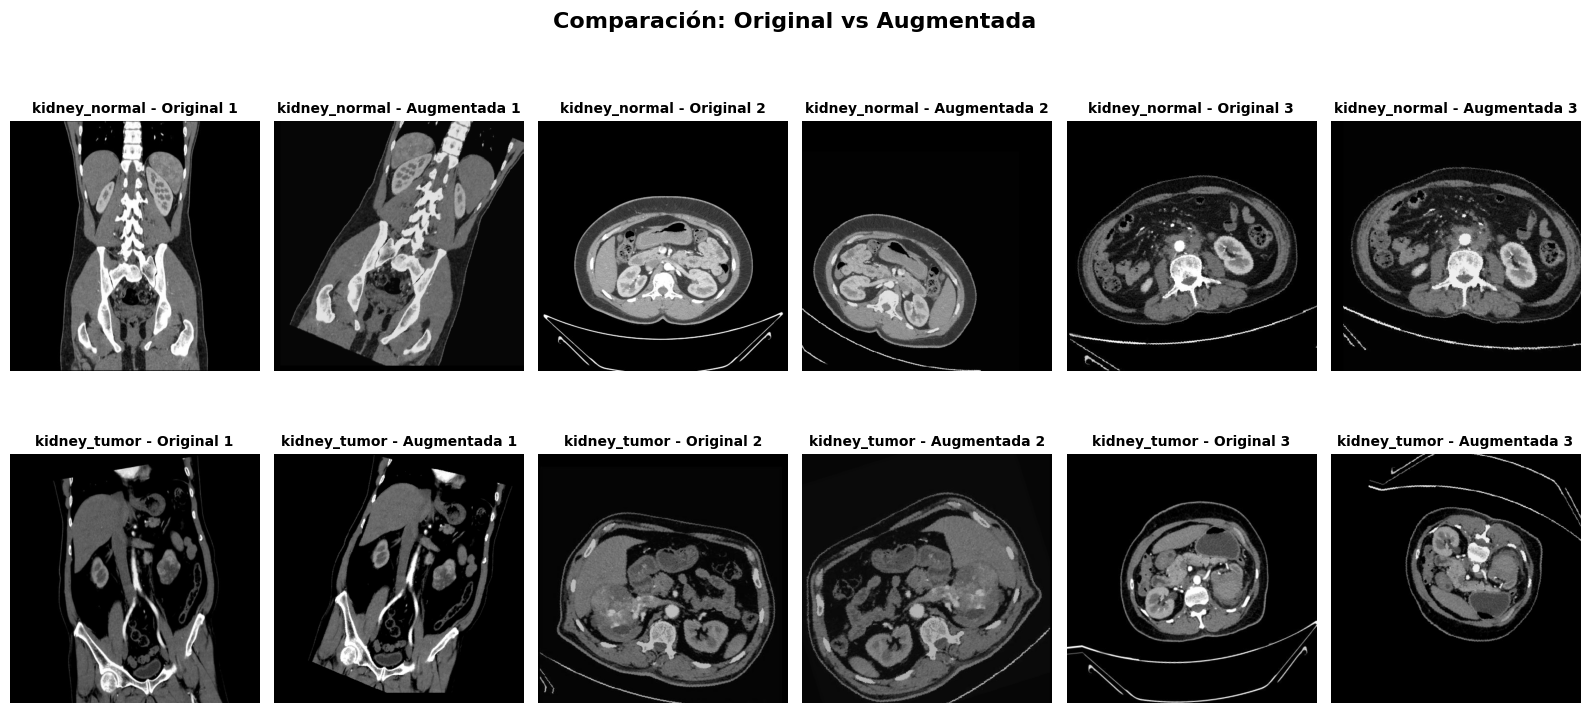

: 

In [ ]:
# Ver algunos ejemplos del dataset final (incluyendo imágenes aumentadas)
print("\n🎨 Visualizando ejemplos del dataset final...\n")
visualizar_augmentacion(EJEMPLOS_A_MOSTRAR)

## 9. Resumen 
✅ **Completado:**
- Dataset aumentado con 1000 imágenes adicionales por clase
- Cada clase ahora tiene aproximadamente 6000 imágenes
- Transformaciones aplicadas: rotación, flips, ajustes de color y transformaciones afines
